Librerías

In [1]:
!pip install chess
!apt-get install unrar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [1]:
import chess
import numpy as np
import chess.pgn
import math
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import chess.engine
import random
import gc


Descomprimir el dataset

In [3]:
import os

def unrar(file_path, extract_path='.'):
    os.system(f'unrar x "{file_path}" "{extract_path}"')


# Example usage
rar_file_path = '/content/Dataset_Entrenamiento.rar'
extract_path1 = '/content/'


# Unzip .rar file
unrar(rar_file_path, extract_path1)



Cargamos el dataset

In [2]:
file1='/content/Nueva_Data_Numpy_1/dataset_partidas_1.npy'
file2='/content/Nueva_Data_Numpy_1/labels_partidas_1.npy'
file3='/content/Nueva_Data_Numpy_1/dataset_partidas_3.npy'
file4='/content/Nueva_Data_Numpy_1/labels_partidas_3.npy'

In [3]:
dataset1 = np.load(file1)
labels1 = np.load(file2)
dataset2 = np.load(file3)
labels2 = np.load(file4)

In [4]:
dataset=np.concatenate((dataset1,dataset2))
labels=np.concatenate((labels1,labels2))

del dataset1
del labels1
del dataset2
del labels2
gc.collect()

0

In [5]:
len(dataset)

397641

Creamos dataset de tensorflow, barajamos y creamos un set de validación.

In [6]:
# Tensorflow dataser
dataset = tf.data.Dataset.from_tensor_slices((dataset, labels))

del labels
gc.collect()

# Barajar
dataset = dataset.shuffle(buffer_size=len(dataset))

# Validación
split_ratio = 0.9
split_index = int(len(dataset) * split_ratio)

train_dataset = dataset.take(split_index)
val_dataset = dataset.skip(split_index)

# Batch 
batch_size = 32
train_dataset = train_dataset.batch(batch_size)

# Batch 
val_dataset = val_dataset.batch(batch_size)


In [7]:
print(len(train_dataset))
print(len(val_dataset))

11184
1243


Creamos la red neuronal

In [10]:
# Input
input1 = tf.keras.Input(shape=(17, 8, 8))

# Capas convolucionales
conv1 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(input1)
norm1 = layers.BatchNormalization()(conv1)
relu1 = layers.Activation('relu')(norm1)

conv2 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(relu1)
norm2 = layers.BatchNormalization()(conv2)
relu2 = layers.Activation('relu')(norm2)

conv3 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(relu2)
norm3 = layers.BatchNormalization()(conv3)
relu3 = layers.Activation('relu')(norm3)

conv4 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(relu3)
norm4 = layers.BatchNormalization()(conv4)
relu4 = layers.Activation('relu')(norm4)

conv5 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(relu4)
norm5 = layers.BatchNormalization()(conv5)
relu5 = layers.Activation('relu')(norm5)


conv6 = layers.Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='same')(relu5)
norm6 = layers.BatchNormalization()(conv6)
relu6 = layers.Activation('relu')(norm6)

# Flatten
flatten = layers.Flatten()(relu6)

dense1 = layers.Dense(128, activation='relu')(flatten)
output_layer = layers.Dense(1, activation='linear')(dense1)

# Modelo
model = models.Model(inputs=[input1], outputs=output_layer)


learning_rate = 0.001

# Optimizador
optimizer = Adam(learning_rate=learning_rate)

# Compilar
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Resumen
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 17, 8, 8)]        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 8, 128)        9344      
                                                                 
 batch_normalization_6 (Bat  (None, 17, 8, 128)        512       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 17, 8, 128)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 8, 128)        147584    
                                                                 
 batch_normalization_7 (Bat  (None, 17, 8, 128)        512       
 chNormalization)                                          

Entrenamos

In [11]:
epochs = 30
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/30
11184/11184 [==============================] - 106s 9ms/step - loss: 5350977.5000 - mae: 865.1548 - val_loss: 4801223.0000 - val_mae: 804.1387
Epoch 2/30
11184/11184 [==============================] - 89s 8ms/step - loss: 4694757.5000 - mae: 833.9952 - val_loss: 4380379.0000 - val_mae: 859.7321
Epoch 3/30
11184/11184 [==============================] - 93s 8ms/step - loss: 4417713.5000 - mae: 803.2002 - val_loss: 4094569.5000 - val_mae: 760.7051
Epoch 4/30
11184/11184 [==============================] - 90s 8ms/step - loss: 4175865.5000 - mae: 783.8777 - val_loss: 3895409.5000 - val_mae: 749.8892
Epoch 5/30
11184/11184 [==============================] - 88s 8ms/step - loss: 3895035.0000 - mae: 753.5534 - val_loss: 3710859.2500 - val_mae: 712.5275
Epoch 6/30
11184/11184 [==============================] - 90s 8ms/step - loss: 3675817.0000 - mae: 736.3111 - val_loss: 3521190.7500 - val_mae: 830.5017
Epoch 7/30
11184/11184 [==============================] - 89s 8ms/step - loss: 33

Guardamos

In [12]:
model.save('Crimson_Red_v10_30e.keras')
model.save('Crimson_Red_v10_30e.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Graficamos métricas

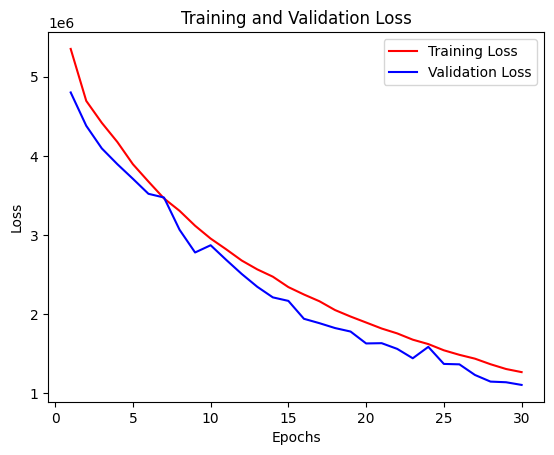

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history


loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'r', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Entrenamos mas

In [14]:
epochs = 20
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/20
11184/11184 [==============================] - 96s 9ms/step - loss: 1229316.5000 - mae: 462.9585 - val_loss: 1060379.7500 - val_mae: 434.4523
Epoch 2/20
11184/11184 [==============================] - 88s 8ms/step - loss: 1175350.7500 - mae: 458.0426 - val_loss: 1103520.7500 - val_mae: 454.5362
Epoch 3/20
11184/11184 [==============================] - 89s 8ms/step - loss: 1144813.6250 - mae: 451.2976 - val_loss: 1071494.3750 - val_mae: 423.4660
Epoch 4/20
11184/11184 [==============================] - 87s 8ms/step - loss: 1103231.7500 - mae: 444.0266 - val_loss: 933502.4375 - val_mae: 399.7881
Epoch 5/20
11184/11184 [==============================] - 87s 8ms/step - loss: 1053567.8750 - mae: 436.4756 - val_loss: 834113.1250 - val_mae: 393.6234
Epoch 6/20
11184/11184 [==============================] - 89s 8ms/step - loss: 1017058.7500 - mae: 431.7201 - val_loss: 869521.4375 - val_mae: 389.2899
Epoch 7/20
11184/11184 [==============================] - 90s 8ms/step - loss: 979163

In [15]:
model.save('Crimson_Red_v10_50e.keras')
model.save('Crimson_Red_v10_50e.h5')

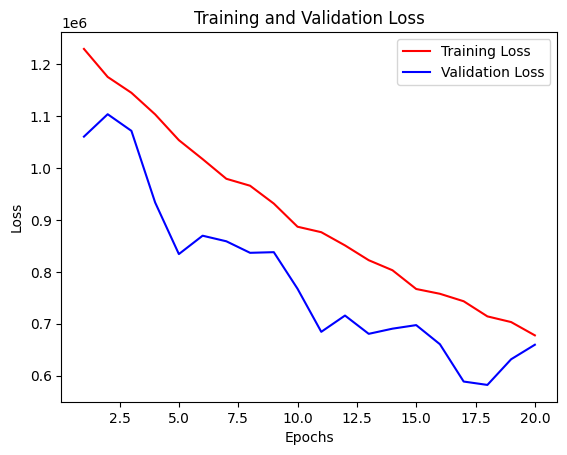

In [16]:
import matplotlib.pyplot as plt

# Assuming history is a dictionary containing the training history
history_dict = history.history

# Plot training and validation loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'r', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
